# Computing Galactic Orbits of Stars with Gala

## Authors
Adrian Price-Whelan, Stephanie T. Douglas

## Learning Goals
* Query the Gaia data release 2 catalog to retrieve data for a sample of well-measured, nearby stars
* Define high-mass and low-mass stellar samples using color-magnitude selections
* Calculate orbits of the high-mass and low-mass stars within the Galaxy to show that the typically younger stars (high-mass) have smaller vertical excursions

## Keywords
coordinates, astroquery, gala, galactic dynamics, astrometry, matplotlib, scatter plot, histogram


## Companion Content
Astropy Docs: [Description of the Galactocentric frame in astropy coordinates](
http://docs.astropy.org/en/latest/generated/examples/coordinates/plot_galactocentric-frame.html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py)

## Summary

We will use data from the [Gaia mission](https://www.cosmos.esa.int/web/gaia) to get sky positions, distances (parallaxes), proper motions, and radial velocities for a set of stars that are close to the Sun. We will then transform these observed, heliocentric kinematic measurements to Galactocentric Cartesian coordinates and use the positions and velocities as initial conditions to compute the orbits of these stars in the galaxy using the [gala](http://gala.adrian.pw) Python package. We will compare the orbits of high-mass main sequence (i.e. young) stars to the orbits of lower-mass main sequence stars to show that young stars have smaller vertical amplitudes.

In [1]:
with open('requirements.txt') as f:
    print(f"Required packages for this notebook:\n{f.read()}")

Required packages for this notebook:
astropy
astroquery>=0.4.8.dev9474  # 2024-09-24 pinned for Gaia column capitalization issue
gala
matplotlib
numpy
scipy



## Installing Dependencies

This tutorial depends on the Astropy affiliated packages `gala` and `astroquery`. Both of these packages can be pip-installed with:

    pip install gala astroquery

## Imports

In [4]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 10.7 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 10.8 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 10.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 11.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24/24 [astroquery]4 [astroquery]y]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


## Importación de Librerias
(astropy, astroquery, gala, matplotlib, numpy)

In [50]:
# astropy imports
import astropy.coordinates as coord
from astropy.table import QTable
import astropy.units as u
from astroquery.gaia import Gaia

print("¡astroquery funciona!")

# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# gala imports
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

print("¡Gala está funcionando!")

¡astroquery funciona!
¡Gala está funcionando!


## Scientific Background

[The Gaia mission](https://www.cosmos.esa.int/web/gaia/) is an ESA mission that aims to measure the 3D positions and velocities of a large number of stars throughout the Milky Way. The primary mission objective is to enable studying the formation, structure, and evolutionary history of our Galaxy by measuring astrometry (sky position, parallax, and proper motion) for about 2 billion stars brighter than the Gaia $G$-band photometric magnitude $G \lesssim 21$. By end of mission (~2022), Gaia will also provide multi-band photometry and low-resolution spectrophotometry for these sources, along with radial or line-of-sight velocities for a subsample of about 100 million stars.

In April 2018, Gaia publicly released its first major catalog of data — data release 2 or DR2 — which provides a subset of these data to anyone with an internet connection. In this tutorial, we will use astrometry, radial velocities, and photometry for a small subset of DR2 to study the kinematics of different types of stars in the Milky Way.

## Using `astroquery` to retrieve Gaia data

We'll start by querying the [Gaia science archive](http://gea.esac.esa.int/archive/) to download astrometric and kinematic data (parallax, proper motion, radial velocity) for a sample of stars near the Sun. We'll use data exclusively from [data release 2 (DR2)](https://www.cosmos.esa.int/web/gaia/data-release-2) from the *Gaia* mission. For the demonstration here, let's grab data for a random subset of 4096 stars within a distance of 100 pc from the Sun that have high signal-to-noise astrometric measurements.

To perform the query and to retrieve the data, we'll use the *Gaia* module in the [astroquery](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html) package, `astroquery.gaia`. This module expects us to provide an SQL query to select the data we want (technically it should be an [ADQL](https://gea.esac.esa.int/archive-help/adql/index.html) query, which is similar to SQL but provides some additional functionality for astronomy; to learn more about ADQL syntax and options, [this guide](https://www.gaia.ac.uk/data/gaia-data-release-1/adql-cookbook) provides an introduction). We don't need all of the columns that are available in DR2, so we'll limit our query to request the sky position (`ra`, `dec`), parallax, proper motion components (`pmra`, `pmdec`), radial velocity, and magnitudes (`phot_*_mean_mag`). More information about the available columns is in the [Gaia DR2 data model](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html). 

To select stars that have high signal-to-noise parallaxes, we'll use the filter ``parallax_over_error > 10`` to select stars that have small fractional uncertainties. We'll also use the filter ``radial_velocity IS NOT null`` to only select stars that have measured radial velocities.

## Defición de la consulta Gaia

In [51]:
query_text = '''SELECT TOP 4096 ra, dec, parallax, pmra, pmdec, radial_velocity,
phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr2.gaia_source
WHERE parallax_over_error > 10 AND
    parallax > 10 AND
    radial_velocity IS NOT null
ORDER BY random_index
'''

We now pass this query to the `Gaia.launch_job()` class method to create an anonymous job in the `Gaia` science archive to run our query. To retrieve the results of this query as an Astropy `Table` object, we then use the `job.get_results()` method. Note that you may receive a number of warnings (output lines that begin with ``WARNING:``) from the ``astropy.io.votable`` package — these are expected, and it's OK to ignore these warnings (the `Gaia` archive returns a slightly invalid VOTable).

## Ejecutar la consulta y cargar datos


In [52]:
# Note: the following lines require an internet connection, so we have 
# provided the results of this query as a FITS file included with the 
# tutorials repository. If you have an internet connection, feel free
# to uncomment these lines to retrieve the data with `astroquery`:
job = Gaia.launch_job(query_text)
gaia_data = job.get_results()
gaia_data.write('gaia_data.fits', overwrite=True)

In [53]:
gaia_data = QTable.read('gaia_data.fits')

The `data` object is now an Astropy `Table` called `gaia_data` that contains `Gaia` data for 4096 random stars within 100 pc (or with a parallax > 10 mas) of the Sun, as we requested. Let's look at the first four rows of the table:

In [54]:
gaia_data[:4]

ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mas,mas / yr,mas / yr,km / s,mag,mag,mag
float64,float64,float64,float64,float64,float64,float32,float32,float32
256.8370985186671,46.5081010273448,10.770964834345387,-19.76657104695835,55.92605676622464,-17.673072044811907,12.956912994384766,14.192928314208984,11.859498023986816
129.45826809010867,-6.806694022293258,41.081670013380716,-297.34595349374183,43.83424795415093,35.53814452290586,6.576352119445801,6.931065082550049,6.111272811889648
2.317856723637118,9.00699655780345,17.824765284426462,-171.8278607514459,-1083.8740928197751,-148.91780163518774,13.119074821472168,13.968703269958496,12.223302841186523
330.41287472805976,51.88897801553169,13.0756133009657,-85.30745872006916,-34.23366534215265,-28.726469345049587,12.101919174194336,13.05264949798584,11.149785995483398


Note that the table columns already contain units! They are indicated in the second row of the header.

## Using `astropy.coordinates` to represent and transform stellar positions and velocities

Let's double check that the farthest star is still within 100 pc, as we expect from the parallax selection we did in the query above. To do this, we'll create an Astropy `Distance` object using the parallax (*Note: this inverts the parallax to compute the distance! This is only a good approximation when the parallax signal to noise is large, as we ensured in the query above with `parallax_over_error > 10`*):

## Inspección simple y cálculo de distancias

In [55]:
dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
dist.min(), dist.max()

(<Distance 8.79909291 pc>, <Distance 99.99985292 pc>)

It looks like the closest star in our sample is about 9 pc away, and the farthest is almost 100 pc, as we expected.

We next want to convert the coordinate position and velocity data from heliocentric, spherical values to Galactocentric, Cartesian values. We'll do this using the [Astropy coordinates](http://docs.astropy.org/en/latest/coordinates/index.html) transformation machinery. To make use of this functionality, we first have to create a `SkyCoord` object from the `Gaia` data we downloaded. The `Gaia` DR2 data are in the ICRS (equatorial) reference frame, which is also the default frame when creating new `SkyCoord` objects, so we don't need to specify the frame below:

## Crear SkyCoord con todas las cantidades observacionales

In [56]:
c = coord.SkyCoord(ra=gaia_data['ra'], 
                   dec=gaia_data['dec'],
                   distance=dist,
                   pm_ra_cosdec=gaia_data['pmra'], 
                   pm_dec=gaia_data['pmdec'],
                   radial_velocity=gaia_data['radial_velocity'])

Note: as described in the [Gaia DR2 data model](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html), the Gaia column `pmra` contains the cos(dec) term. In Astropy coordinates, the name of this component is `pm_ra_cosdec`.

Let's again look at the first four coordinates in the `SkyCoord` object:

In [57]:
c[:4]

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(256.83709852, 46.50810103, 92.84219338),
     (129.45826809, -6.80669402, 24.3417563 ),
     (  2.31785672,  9.00699656, 56.1017205 ),
     (330.41287473, 51.88897802, 76.47824825)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [( -19.76657105,    55.92605677,  -17.67307204),
     (-297.34595349,    43.83424795,   35.53814452),
     (-171.82786075, -1083.87409282, -148.91780164),
     ( -85.30745872,   -34.23366534,  -28.72646935)]>

Now that we have a `SkyCoord` object with the Gaia data, we can transform to other coordinate systems. For example, we can transform to the `Galactic` coordinate system (centered on the Sun but with the zero latitude approximately aligned with the Galactic plane) using the `.galactic` attribute (this works for any of the [built-in Astropy coordinate frames](http://docs.astropy.org/en/latest/coordinates/index.html#reference-api), e.g., `.fk5` should also work):

In [58]:
c.galactic[:4]

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [( 72.32926334,  36.8367097 , 92.84219338),
     (232.07542475,  19.9763116 , 24.3417563 ),
     (105.68646983, -52.44715126, 56.1017205 ),
     ( 98.28701089,  -2.66800849, 76.47824825)]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(  55.13035551,   21.88801174,  -17.67307204),
     (-195.30630898, -228.4545973 ,   35.53814452),
     (-455.13470935, -998.57912013, -148.91780164),
     ( -88.74713695,   23.94268239,  -28.72646935)]>

The `Galactic` frame is still centered on the solar system barycenter, whereas we want to compute the positions and velocities of our sample of stars in a Galactocentric frame, centered on the center of the Milky Way. To do this transformation, Astropy provides the `Galactocentric` frame class, which allows us to use our own conventions for, e.g., the distance from the sun to the Galactic center (`galcen_distance`) or the height of the Sun over the Galactic midplane (`z_sun`). Let's look at the default values for the solar position and velocity:

In [59]:
coord.Galactocentric()

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>

We'll instead use a distance of 8.1 kpc — more consistent with the [recent results from the GRAVITY collaboration](https://arxiv.org/abs/1807.09409) — and a solar height of 0 pc. We'll use the default solar velocity (see output above). We can transform our data to this frame using the `transform_to()` method by specifying the `Galactocentric` frame with our adopted values:

## Transformación a sistema Galactocéntrico

In [60]:
galcen = c.transform_to(coord.Galactocentric(z_sun=0*u.pc, 
                                             galcen_distance=8.1*u.kpc))

The `galcen` object now contains the data for our sample, but in the Galactocentric frame:

In [61]:
galcen[:4]

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.1 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=0.0 pc, roll=0.0 deg): (x, y, z) in pc
    [(-8077.44468803,  70.79989896,  55.66242071),
     (-8114.06090109, -18.04601124,   8.31586669),
     (-8109.24493623,  32.92015736, -44.47693151),
     (-8111.0109288 ,  75.59768012,  -3.55986822)]
 (v_x, v_y, v_z) in km / s
    [(-16.26556759, 233.98501167,   4.89424163),
     (-30.94107553, 226.00094753,  -4.85474972),
     (210.89926667, -11.75804787, -36.02277769),
     ( 48.81632893, 222.24147077,  17.78803683)]>

We can access the positions of the stars using the `.x`, `.y`, and `.z` attributes, for example:

## Visualizaciones simples

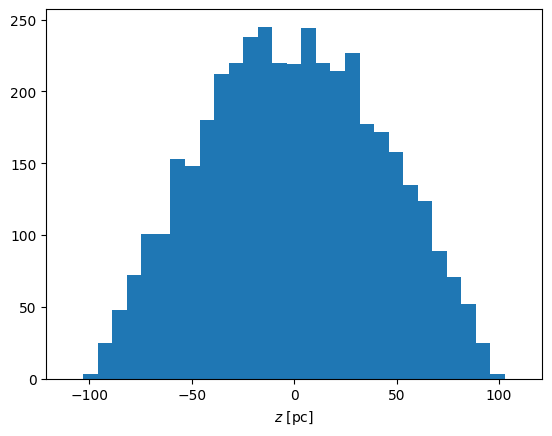

In [62]:
plt.hist(galcen.z.value, bins=np.linspace(-110, 110, 32))
plt.xlabel('$z$ [{0:latex_inline}]'.format(galcen.z.unit));

Similarly, for the velocity components, we can use `.v_x`, `.v_y`, and `.v_z`. For example, to create a classic "UV" plane velocity plot:

Text(0, 0.5, '$v_y$ [$\\mathrm{km\\,s^{-1}}$]')

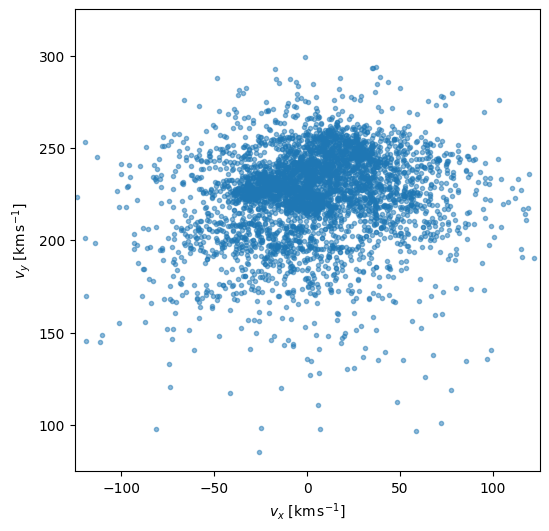

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(galcen.v_x.value, galcen.v_y.value,
        marker='.', linestyle='none', alpha=0.5)

ax.set_xlim(-125, 125)
ax.set_ylim(200-125, 200+125)

ax.set_xlabel('$v_x$ [{0:latex_inline}]'.format(u.km/u.s))
ax.set_ylabel('$v_y$ [{0:latex_inline}]'.format(u.km/u.s))

Along with astrometric and radial velocity data, `Gaia` also provides photometric data for three photometric bandpasses: the broad-band `G`, the blue `BP`, and the red `RP` magnitudes. Let's make a Gaia color-magnitude diagram using the $G_{\rm BP}-G_{\rm RP}$ color and the absolute $G$-band magnitude $M_G$. We'll compute the absolute magnitude using the distances we computed earlier — Astropy `Distance` objects have a convenient `.distmod` attribute that provides the distance modulus:

## Calcular color y magnitud absoluta con paralaje

In [64]:
M_G = gaia_data['phot_g_mean_mag'] - dist.distmod
BP_RP = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']

Text(0, 0.5, '$M_G$')

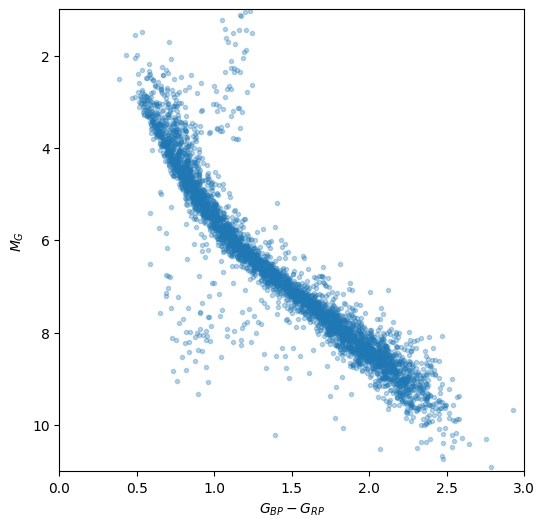

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(BP_RP.value, M_G.value, 
        marker='.', linestyle='none', alpha=0.3)

ax.set_xlim(0, 3)
ax.set_ylim(11, 1)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

In the above, there is a wide range of main sequence star masses which have a range of lifetimes. The most massive stars were likely born in the thin disk and their orbits therefore likely have smaller vertical amplitudes than the typical old main sequence star. To compare, we'll create two sub-selections of the Gaia CMD to select massive and low-mass main sequence stars from the CMD for comparison. You may see two ``RuntimeWarning``(s) from running the next cell — these are expected and it's safe to ignore them.

In [66]:
np.seterr(invalid="ignore")
hi_mass_mask = ((BP_RP > 0.5*u.mag) & (BP_RP < 0.7*u.mag) & 
                (M_G > 2*u.mag) & (M_G < 3.75*u.mag) & 
                (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))

lo_mass_mask = ((BP_RP > 2*u.mag) & (BP_RP < 2.4*u.mag) & 
                (M_G > 8.2*u.mag) & (M_G < 9.7*u.mag) &
                (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))

Let's also define default colors to use when visualizing the high- and low-mass stars:

In [67]:
hi_mass_color = 'tab:purple'
lo_mass_color = 'tab:red'

Let's now visualize these two CMD selections:

Text(0, 0.5, '$M_G$')

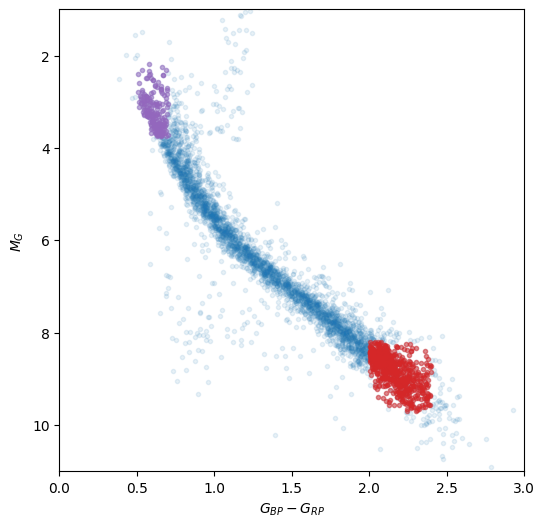

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(BP_RP.value, M_G.value, 
        marker='.', linestyle='none', alpha=0.1)

for mask, color in zip([lo_mass_mask, hi_mass_mask],
                       [lo_mass_color, hi_mass_color]):
    ax.plot(BP_RP[mask].value, M_G[mask].value, 
            marker='.', linestyle='none', 
            alpha=0.5, color=color)

ax.set_xlim(0, 3)
ax.set_ylim(11, 1)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

Thus far, we've used the color-magnitude diagram (using parallaxes and photometry from Gaia to compute absolute magnitudes) to select samples of high- and low-mass stars based on their colors.

In what follows, we'll compute Galactic orbits for stars in the high- and low-mass star selections above and compare.

## Using `gala` to numerically integrate Galactic stellar orbits

`gala` is an Astropy affiliated package for Galactic dynamics. `gala` provides functionality for representing analytic mass models that are commonly used in Galactic dynamics contexts for numerically integrating stellar orbits. For examples, see Chapter 3 of Binney and Tremaine (2008). The gravitational potential models are defined by specifying parameters like mass, scale radii, or shape parameters and can be combined. Once defined, they can be used in combination with numerical integrators provided in `gala` to compute orbits. `gala` comes with a pre-defined, multi-component, but [simple model for the Milky Way](http://gala.adrian.pw/en/latest/potential/define-milky-way-model.html) that can be used for orbit integrations. Let's create an instance of the `MilkyWayPotential` model and integrate orbits for the high- and low-mass main sequence stars selected above:

In [69]:
milky_way = gp.MilkyWayPotential()
milky_way

<CompositePotential disk,bulge,nucleus,halo>

This model has mass components for the Galactic disk, bulge, nucleus, and halo, and the parameters were defined by fitting measurements of the Milky Way enclosed mass at various radii. See [this document](http://gala.adrian.pw/en/latest/potential/define-milky-way-model.html) for more details. The parameters of the `MilkyWayPotential` can be changed by passing in a dictionary of parameter values to argument names set by the component names. For example, to change the disk mass to make it slightly more massive (the choice `8e10` is arbitrary!):

In [70]:
different_disk_potential = gp.MilkyWayPotential(disk=dict(m=8e10*u.Msun))
different_disk_potential

<CompositePotential disk,bulge,nucleus,halo>

To integrate orbits, we have to combine the mass model with a reference frame into a `Hamiltonian` object. If no reference frame is passed in, it's assumed that we are in a static inertial frame moving with the center of the mass model:

In [71]:
H = gp.Hamiltonian(milky_way)

Now that we have the mass model, we can integrate orbits. Let's now define initial conditions for subsets of the high- and low-mass star selections we did above. Initial conditions in `gala` are specified by creating `PhaseSpacePosition` objects. We can create these objects directly from a `Galactocentric` object, like we have defined above from transforming the Gaia data — we first have to extract the data with a Cartesian representation. We can do this by calling `galcen.cartesian`:

In [72]:
w0_hi = gd.PhaseSpacePosition(galcen[hi_mass_mask].cartesian)
w0_lo = gd.PhaseSpacePosition(galcen[lo_mass_mask].cartesian)
w0_hi.shape, w0_lo.shape

((185,), (593,))

From the above, we can see that we have 185 high-mass star and 577 low-mass stars in our selections. To integrate orbits, we call the `.integrate_orbit()` method on the Hamiltonian object we defined above, and pass in initial conditions. We also have to specify the timestep for integration, and how long we want to integrate for. We can do this by either specifying the amount of time to integrate for, or by specifying the number of timesteps. Let's specify a timestep of 1 Myr and a time of 500 Myr (approximately two revolutions around the Galaxy for a Sun-like orbit):

## Integración de órbitas

In [73]:
orbits_hi = H.integrate_orbit(w0_hi, dt=1*u.Myr, 
                              t1=0*u.Myr, t2=500*u.Myr)

orbits_lo = H.integrate_orbit(w0_lo, dt=1*u.Myr, 
                              t1=0*u.Myr, t2=500*u.Myr)

        Use name instead. [gala.dynamics.core]


By default this uses a [Leapfrog](https://en.wikipedia.org/wiki/Leapfrog_integration) numerical integration scheme, but the integrator can be customized — see the `gala` [examples](http://gala.adrian.pw/en/latest/examples/integrate-potential-example.html) for more details.

With the orbit objects in hand, we can continue our comparison of the orbits of high-mass and low-mass main sequence stars in the solar neighborhood. Let's start by plotting a few orbits. The `.plot()` convenience function provides a quick way to visualize orbits in three Cartesian projections. For example, let's plot the first orbit in each subsample on the same figure:

        Use name instead. [gala.dynamics.orbit]
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


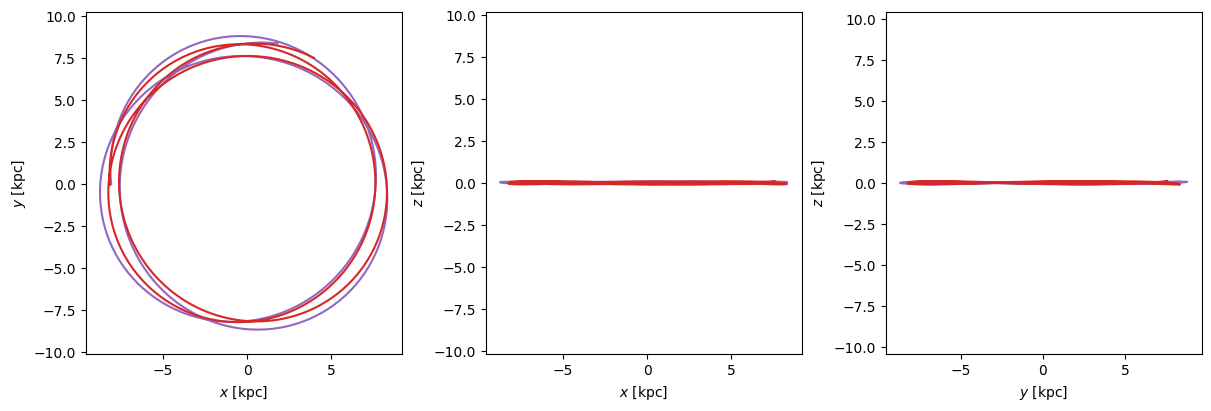

In [74]:
fig = orbits_hi[:, 184].plot(color=hi_mass_color)
_ = orbits_lo[:, 592].plot(axes=fig.axes, color=lo_mass_color)

Note in the above figure that the orbits are almost constrained to the x-y plane: the excursions are much larger in the x and y directions as compared to the z direction.

The default plots show all Cartesian projections. This can be customized to, for example, only show specified components (including velocity components):

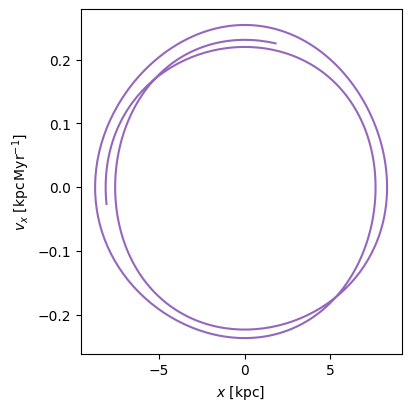

In [29]:
fig = orbits_hi[:, 184].plot(['x', 'v_x'], 
                           auto_aspect=False, 
                           color=hi_mass_color)

The representation can also be changed, for example, to a cylindrical representation:

(-0.3, 0.3)

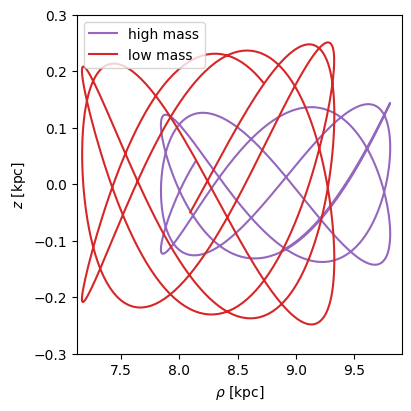

In [30]:
fig = orbits_hi[:, 0].cylindrical.plot(['rho', 'z'], 
                                       color=hi_mass_color,
                                       label='high mass')
_ = orbits_lo[:, 0].cylindrical.plot(['rho', 'z'], color=lo_mass_color,
                                     axes=fig.axes,
                                     label='low mass')

fig.axes[0].legend(loc='upper left')
fig.axes[0].set_ylim(-0.3, 0.3)

Already in the above plot we can see that the high-mass star has an orbit with smaller eccentricity (smaller radial variations) and smaller vertical oscillations as compared to the low-mass star. Below, we'll quantify this and look at the vertical excursions of all of the high- and low-mass stars, respectively.

Let's now compare the vertical amplitudes of the orbits in each of our sub-selections! We can compute the (approximate) maximum vertical height of each orbit using the convenience method `.zmax()` (you can see a list of all convenience methods on the `Orbit` object [in the Gala documentation here](http://gala.adrian.pw/en/latest/api/gala.dynamics.Orbit.html#gala.dynamics.Orbit)):

In [75]:
zmax_hi = orbits_hi.zmax(approximate=True)
zmax_lo = orbits_lo.zmax(approximate=True)

Let's make histograms of the maximum $z$ heights for these two samples:

Text(0.5, 0, '$z_{\\rm max}$ [$\\mathrm{kpc}$]')

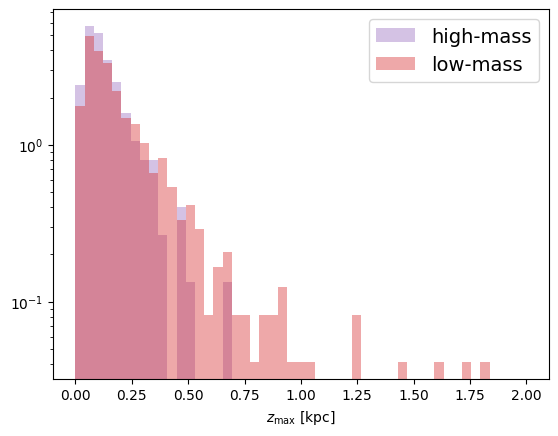

In [32]:
bins = np.linspace(0, 2, 50)

plt.hist(zmax_hi.value, bins=bins, 
         alpha=0.4, density=True, label='high-mass', 
         color=hi_mass_color)
plt.hist(zmax_lo.value, bins=bins, 
         alpha=0.4, density=True, label='low-mass',
         color=lo_mass_color);

plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"$z_{\rm max}$" + " [{0:latex}]".format(zmax_hi.unit))

The distribution of $z$-heights for the low-mass (i.e. typically older) stars is more extended, as we predicted!

In this tutorial, we've used `astroquery` to query the Gaia science archive to retrieve kinematic and photometric data for a small sample of stars with well-measured parallaxes from Gaia DR2. We used the colors and absolute magnitudes of these stars to select subsamples of high- and low-mass stars, which, on average, will provide us with subsamples of stars that are younger and older, respectively. We then constructed a model for the gravitational field of the Milky Way and numerically integrated the orbits of all stars in each of the two subsamples. Finally, we used the orbits to compute the maximum height that each star reaches above the Galactic midplane and showed that the younger (higher-mass) stars tend to have smaller excursions from the Galactic plane, consistent with the idea that stars are either born in a "thinner" disk and dynamically "heated," or that older stars formed with a larger vertical scale-height.

## Exercises

1. Some of the low-mass star orbits have large vertical excursions from the Galactic disk (up to and above 1.5 kpc) and could therefore be stellar halo stars rather than part of the Galactic disk. Use the zmax values to select a few of these stars and plot their full orbits. Do these stars look like they are part of the disk? Why / why not?
2. [Orbit](http://gala.adrian.pw/en/latest/dynamics/orbits-in-detail.html) objects also provide methods for computing apocenter and pericenter distances and eccentricities. Which types of stars (high-mass or low-mass) tend to have high eccentricity orbits within the Galaxy? Similar to the plot above, make a plot showing the two distributions of eccentricity values.

## Ejercicio 1: Estrellas del halo y del disco

En este ejercicio se analizan las estrellas de baja y alta masa según su amplitud vertical en la galaxia.  
El objetivo es identificar cuáles de ellas podrían pertenecer al halo galáctico, en lugar del disco, utilizando el valor de `zmax`, que representa la altura máxima alcanzada sobre el plano galáctico.

Una estrella con `zmax` mayor que ~1.5 kpc suele considerarse parte del halo estelar, ya que se aleja significativamente del disco galáctico.


### Cálculo de la altura máxima `zmax`

Aquí se calculan las alturas máximas (`zmax`) que alcanzan las órbitas de estrellas de alta y baja masa.  
La opción `approximate=True` permite obtener una estimación rápida de este valor a partir de las órbitas previamente integradas.


In [38]:
zmax_hi = orbits_hi.zmax(approximate=True)
zmax_lo = orbits_lo.zmax(approximate=True)

### Selección de estrellas de baja masa tipo halo

En esta celda se filtran las estrellas de **baja masa** cuya `zmax` supera 1.5 kpc.  
Esto permite aislar las candidatas a pertenecer al halo. Luego se imprime cuántas cumplen la condición y se seleccionan algunas para visualizarlas.


In [76]:
# Seleccionar las estrellas de baja masa con zmax > 1.5 kpc
halo_like_mask = zmax_lo > 1.5 * u.kpc

# Cuántas hay
print(f"Número de estrellas con zmax > 1.5 kpc: {np.sum(halo_like_mask)}")

# Selecciona algunas (por ejemplo las primeras 5)
indices_halo_like = np.where(halo_like_mask)[0][:5]
print("Índices seleccionados:", indices_halo_like)


Número de estrellas con zmax > 1.5 kpc: 3
Índices seleccionados: [240 296 479]


### Selección de estrellas de alta masa tipo halo

Se repite el mismo proceso para las **estrellas de alta masa**: se filtran aquellas con `zmax > 1.5 kpc`, se cuenta su número y se seleccionan algunos ejemplos.  
Esto permite comparar la distribución vertical de estrellas de diferentes masas.


Número de estrellas de alta masa con zmax > 1.5 kpc: 1
Índices seleccionados (alta masa): [13]


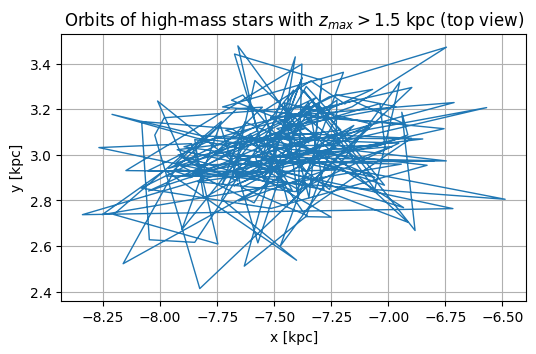

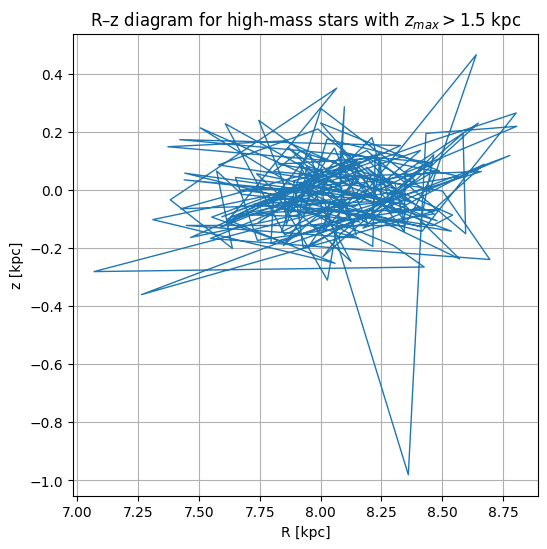

In [80]:
# Filtrar estrellas de alta masa con zmax > 1.5 kpc
hi_halo_like_mask = zmax_hi > 1.5 * u.kpc

print(f"Número de estrellas de alta masa con zmax > 1.5 kpc: {np.sum(hi_halo_like_mask)}")

# Seleccionar hasta 5 índices
indices_hi_halo_like = np.where(hi_halo_like_mask)[0][:5]
print("Índices seleccionados (alta masa):", indices_hi_halo_like)

# Seleccionar órbitas correspondientes
selected_orbits_hi = orbits_hi[indices_hi_halo_like]

# Vista superior (x-y)
plt.figure(figsize=(6, 6))
for orbit in selected_orbits_hi:
    plt.plot(orbit.x.value, orbit.y.value, lw=1)
plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")
plt.title("Orbits of high-mass stars with $z_{max} > 1.5$ kpc (top view)")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()

# Diagrama R–z
plt.figure(figsize=(6, 6))
for orbit in selected_orbits_hi:
    R = np.sqrt(orbit.x**2 + orbit.y**2)
    plt.plot(R.value, orbit.z.value, lw=1)
plt.xlabel("R [kpc]")
plt.ylabel("z [kpc]")
plt.title("R–z diagram for high-mass stars with $z_{max} > 1.5$ kpc")
plt.grid(True)
plt.show()

### Selección final de órbitas para graficar

En esta celda se guardan las órbitas seleccionadas de baja masa (las candidatas al halo) en la variable `selected_orbits`.  
Estas órbitas se usarán en las gráficas posteriores.


In [78]:
selected_orbits = orbits_lo[indices_halo_like]

### Vista superior de las órbitas seleccionadas

Aquí se trazan las órbitas de las estrellas seleccionadas en el plano XY, mostrando la proyección “desde arriba” del disco galáctico.  
Si las órbitas se extienden ampliamente y no son circulares, es una señal de que pertenecen al halo y no al disco delgado.


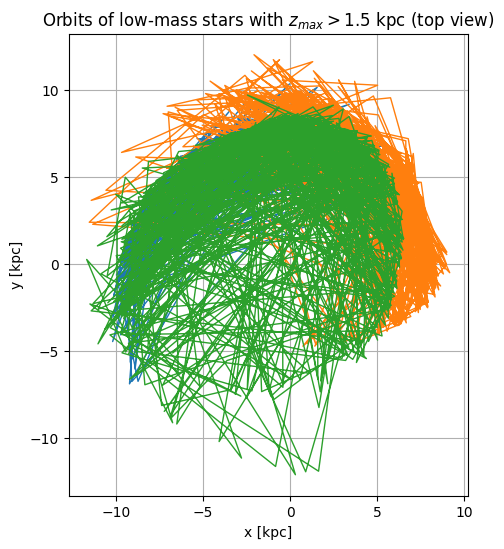

In [79]:
plt.figure(figsize=(6, 6))

for orbit in selected_orbits:
    plt.plot(orbit.x.value, orbit.y.value, lw=1)

plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")
plt.title("Orbits of low-mass stars with $z_{max} > 1.5$ kpc (top view)")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()


### Ejemplo de una órbita individual - Estrella 1

Se grafica la trayectoria de una de las estrellas seleccionadas.  
El objetivo es observar su movimiento en el plano galáctico y notar si su órbita es más excéntrica o caótica, típica de las estrellas del halo.


Text(0.5, 1.0, 'Single orbit of a halo-like star')

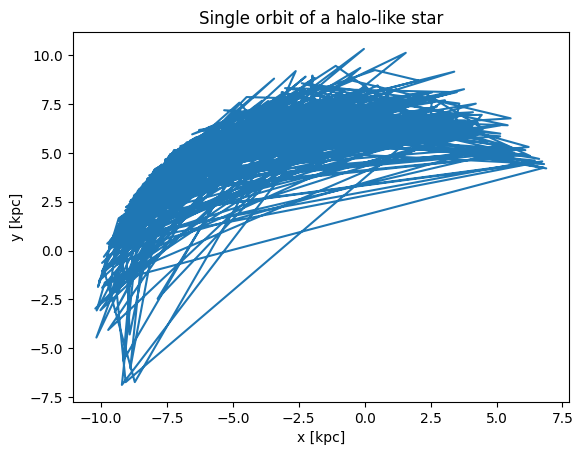

In [45]:
orbit = selected_orbits[0]
plt.plot(orbit.x, orbit.y)
plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")
plt.title("Single orbit of a halo-like star")


### Ejemplo de otra órbita individual - Estrella 2

Se repite el gráfico anterior para una segunda estrella, esta vez usando otro color.  
Comparar distintas órbitas ayuda a ver la diversidad de trayectorias en las regiones del halo.


Text(0.5, 1.0, 'Single orbit of a halo-like star')

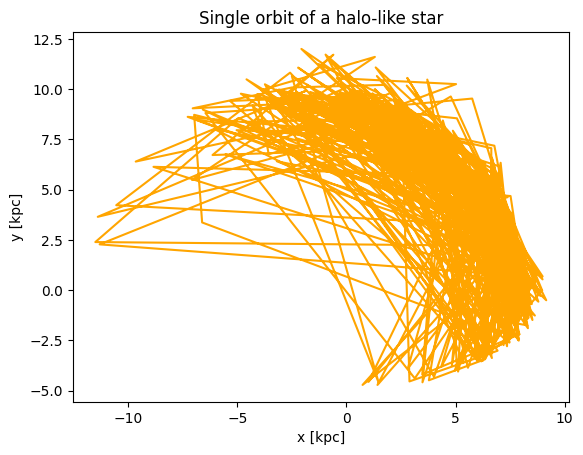

In [48]:
orbit = selected_orbits[1]
plt.plot(orbit.x, orbit.y, color='orange')
plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")
plt.title("Single orbit of a halo-like star")


### Ejemplo de otra órbita individual - Estrella 3

Se grafica una tercera órbita de baja masa, nuevamente con color diferente.  
La comparación de estas trayectorias revela si las estrellas siguen patrones coherentes con el disco o se dispersan en direcciones variadas.


Text(0.5, 1.0, 'Single orbit of a halo-like star')

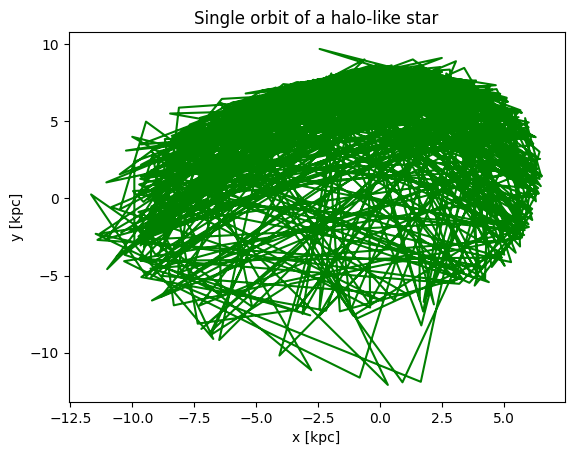

In [49]:
orbit = selected_orbits[2]
plt.plot(orbit.x, orbit.y, color='green')
plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")
plt.title("Single orbit of a halo-like star")

### Diagrama R–z: estructura vertical de las órbitas

En este bloque se calcula el radio cilíndrico `R = √(x² + y²)` para cada punto de las órbitas y se grafica `z` frente a `R`.  
El resultado es un **diagrama R–z**, útil para visualizar la extensión vertical y radial de las trayectorias.  
Las estrellas del halo suelen tener trayectorias que cubren una amplia gama de alturas `z`, a diferencia de las delgado disco galáctico.


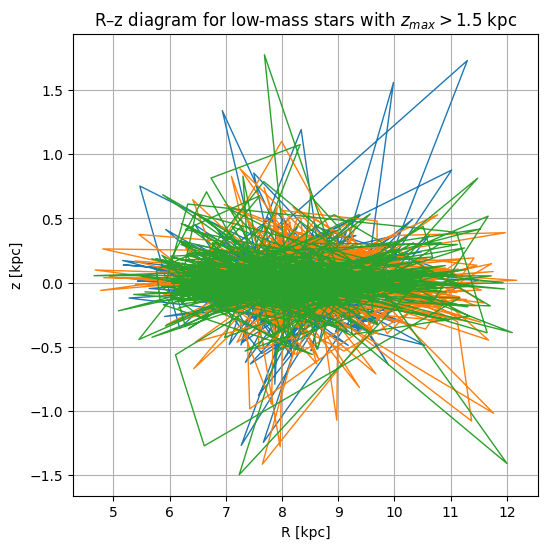

In [44]:
plt.figure(figsize=(6, 6))

for orbit in selected_orbits:
    R = np.sqrt(orbit.x**2 + orbit.y**2)
    plt.plot(R.value, orbit.z.value, lw=1)

plt.xlabel("R [kpc]")
plt.ylabel("z [kpc]")
plt.title("R–z diagram for low-mass stars with $z_{max} > 1.5$ kpc")
plt.grid(True)
plt.show()


### Cálculo de la excentricidad orbital

Finalmente, se calcula la **excentricidad** de cada órbita a partir de los radios de periastro (`rperi`) y apoastro (`rapo`).  
La excentricidad mide cuán elíptica es una órbita: valores cercanos a 0 indican órbitas casi circulares (propias del disco), mientras que valores altos (>0.5) son típicos de estrellas del halo, que siguen trayectorias más alargadas.


High-mass: N = 185, mean = 0.096, median = 0.090
Low-mass:  N = 593, mean = 0.122, median = 0.111


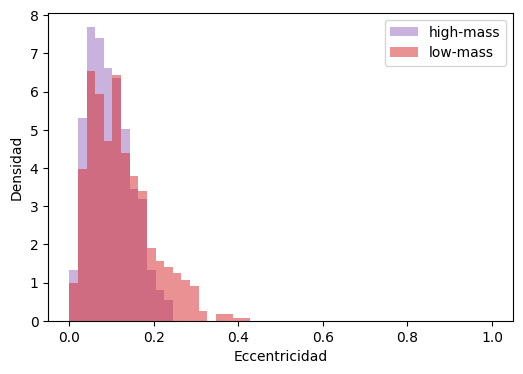

In [81]:
# Calcular excentricidades a partir de rapo y rperi (rho = sqrt(x^2+y^2)) ya disponibles en los objetos Orbit
rho_hi = orbits_hi.cylindrical.rho  # (ntime, n_hi), Quantity en kpc
rperi_hi = rho_hi.min(axis=0)
rapo_hi = rho_hi.max(axis=0)
ecc_hi = (rapo_hi - rperi_hi) / (rapo_hi + rperi_hi)  # Quantity adimensional

rho_lo = orbits_lo.cylindrical.rho  # (ntime, n_lo)
rperi_lo = rho_lo.min(axis=0)
rapo_lo = rho_lo.max(axis=0)
ecc_lo = (rapo_lo - rperi_lo) / (rapo_lo + rperi_lo)

# Convertir a arrays numpy puros (sin unidades) para estadísticas/plot
if hasattr(ecc_hi, 'unit'):
    ecc_hi = ecc_hi.value
if hasattr(ecc_lo, 'unit'):
    ecc_lo = ecc_lo.value

# Evitar posibles divisiones por cero convirtiendo los valores inválidos a NaN
ecc_hi = np.array(ecc_hi, dtype=float)
ecc_lo = np.array(ecc_lo, dtype=float)

# Resumen numérico
print(f"High-mass: N = {ecc_hi.size}, mean = {np.nanmean(ecc_hi):.3f}, median = {np.nanmedian(ecc_hi):.3f}")
print(f"Low-mass:  N = {ecc_lo.size}, mean = {np.nanmean(ecc_lo):.3f}, median = {np.nanmedian(ecc_lo):.3f}")

# Histograma comparativo
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
bins = np.linspace(0, 1, 50)
ax.hist(ecc_hi, bins=bins, alpha=0.5, density=True, label='high-mass', color=hi_mass_color)
ax.hist(ecc_lo, bins=bins, alpha=0.5, density=True, label='low-mass', color=lo_mass_color)
ax.set_xlabel('Eccentricidad')
ax.set_ylabel('Densidad')
ax.legend(loc='best')
plt.show()

## Solución a preguntas planteadas en Clase

### La misión **GAIA**

La misión **GAIA** es un proyecto de la **Agencia Espacial Europea (ESA)** lanzado el **19 de diciembre de 2013**. Su objetivo principal es crear el **mapa tridimensional más preciso y completo de nuestra galaxia, la Vía Láctea**, midiendo la posición, distancia, movimiento y brillo de más de **mil millones de estrellas**.

Para lograrlo, GAIA utiliza un método llamado **astrometría**, que consiste en medir con extrema precisión las posiciones y movimientos propios de las estrellas. Con estos datos, es posible reconstruir las órbitas de las estrellas alrededor del centro galáctico, estudiar la estructura del disco, el halo y el bulbo, y entender la **formación y evolución dinámica de la Vía Láctea**.

Además, GAIA también detecta cúmulos estelares, exoplanetas, asteroides y cuásares, siendo una de las misiones más importantes en astronomía moderna para el estudio de la cinemática y la dinámica galáctica.

---
### La misión **GRAVITY**

La misión **GRAVITY** es un **instrumento interferométrico** instalado en el **Very Large Telescope (VLT)** del Observatorio Europeo Austral (ESO). No es una misión espacial como GAIA, sino un **instrumento terrestre** diseñado para obtener imágenes y mediciones extremadamente precisas del entorno del **agujero negro supermasivo en el centro de la Vía Láctea (Sagittarius A*)**.

GRAVITY combina la luz de los cuatro telescopios principales del VLT mediante interferometría, logrando una resolución equivalente a la de un telescopio de 130 metros de diámetro.
Gracias a GRAVITY, se han podido **observar estrellas orbitando muy cerca del agujero negro central**, confirmando las predicciones de la **relatividad general** y mejorando el entendimiento del núcleo galáctico.

---

### Por qué se centra la velocidad en y entre -200 y 200 km/s

En las simulaciones galácticas y gráficos del notebook, las velocidades suelen representarse en el eje ( y ) o ( v_y ) con un rango de **-200 a 200 km/s**, ya que este intervalo abarca las **velocidades típicas de las estrellas en el disco galáctico**.

* Las estrellas del **disco delgado** giran alrededor del centro galáctico con velocidades cercanas a **220 km/s**, con pequeñas variaciones debidas a perturbaciones gravitacionales o movimientos locales.
* Las estrellas del **halo** o con órbitas más excéntricas pueden desviarse de este valor, alcanzando velocidades más altas o más bajas.

Por tanto, limitar el rango entre -200 y 200 km/s permite **visualizar de forma clara la distribución cinemática** de la mayoría de las estrellas sin perder detalle ni saturar el gráfico con valores extremos poco comunes.

---

### Estructura de una galaxia: disco, bulbo, núcleo y halo

Una galaxia como la Vía Láctea está compuesta por varias estructuras principales, cada una con características físicas y dinámicas distintas:

* **Núcleo galáctico:**
  Es la región más interna y densa, donde reside un **agujero negro supermasivo** (en la Vía Láctea, **Sagittarius A***). Contiene estrellas muy antiguas y gas caliente.

* **Bulbo:**
  Es una estructura esferoidal que rodea el núcleo. Contiene estrellas viejas, con órbitas aleatorias, y es el puente entre el núcleo y el disco.

* **Disco galáctico:**
  Es una estructura delgada y extendida donde se concentran la mayoría de las estrellas jóvenes, el gas y el polvo. Las estrellas del disco giran casi en órbitas **circulares** alrededor del centro galáctico. El disco puede dividirse en:

  * **Disco delgado:** estrellas jóvenes y regiones de formación estelar.
  * **Disco grueso:** estrellas más antiguas, con órbitas más inclinadas y excéntricas.

* **Halo galáctico:**
  Es una región esférica y muy extendida que rodea toda la galaxia. Contiene estrellas viejas, cúmulos globulares y materia oscura. Las estrellas del halo se mueven en **órbitas elípticas** y desordenadas, que pueden alcanzar grandes alturas sobre el plano del disco.

---

### El método numérico **Leapfrog**

El **método Leapfrog** (también conocido como *Verlet integrator*) es un algoritmo numérico ampliamente usado para **resolver ecuaciones de movimiento** en simulaciones de sistemas dinámicos, como las órbitas estelares.

Su nombre “leapfrog” (“saltar la rana”) se debe a que las posiciones y velocidades se calculan **alternadamente**, intercalándose en el tiempo: primero se actualiza la velocidad a medio paso, luego la posición al siguiente paso, y así sucesivamente.

Este método tiene varias ventajas:

* Conserva bien la **energía total del sistema** en simulaciones a largo plazo.
* Es **simple y eficiente computacionalmente**.
* Es **sinfásico** (mantiene la estructura del movimiento periódico).

Por eso es ideal para estudiar **órbitas estelares** o sistemas gravitacionales donde la precisión a largo plazo es más importante que la exactitud instantánea.

---

### Estrellas más excéntricas y su interpretación

En el análisis realizado con los datos de GAIA, se observa que las **estrellas de baja masa (low-mass stars)** suelen presentar **mayores excentricidades** en sus órbitas.

Esto se debe a que muchas de ellas pertenecen al **halo galáctico** o al **disco grueso**, donde las estrellas:

* Han sido perturbadas por interacciones gravitacionales pasadas.
* Pueden provenir de **fusiones de galaxias más pequeñas**.
* Poseen **órbitas más elípticas** y desordenadas.

En cambio, las **estrellas de alta masa** tienden a encontrarse en el **disco delgado**, con **órbitas casi circulares** y excentricidades bajas (( e \approx 0)). Estas estrellas se formaron en regiones con alta densidad de gas y siguen trayectorias regulares alrededor del centro galáctico.
